In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [67]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]

In [2]:
#Select disease
d = "Measles"

#monthly data
monthly_data = pd.read_csv( d +'_data_processed.csv')
time_date = monthly_data.iloc[:,0]

#cumulative monthly data
ecdc_disease_noTime = monthly_data.drop("Time", axis=1)
cumulative_data = ecdc_disease_noTime.apply(lambda x: np.cumsum(x))

In [3]:
print(time_date[0])
print(time_date[len(time_date)-1])

years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1


print(years_run, "--> tmax")


1999-01
2019-12
21 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [20]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
Births_years = Births.iloc[0:(2018-1999+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))

print(Births_UK)

[11.9 11.5 11.3 11.3 11.7 11.9 12.  12.3 12.6 12.8 12.7 12.9 12.8 12.8
 12.1 12.  11.9 11.8 11.4 11. ]


In [21]:
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018
Deaths_years = Deaths.iloc[:,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

print(Deaths_years)
#Deaths_years.iloc[:,0].to_numpy()

       1999      2000      2001      2002      2003      2004      2005  \
0  0.005762  0.005588  0.005570  0.005346  0.005421  0.005194  0.005126   
1  0.000278  0.000236  0.000233  0.000239  0.000244  0.000231  0.000218   
2  0.000118  0.000117  0.000120  0.000109  0.000111  0.000100  0.000096   
3  0.000151  0.000135  0.000146  0.000142  0.000140  0.000124  0.000137   
4  0.000434  0.000423  0.000422  0.000408  0.000380  0.000376  0.000377   
5  0.000651  0.000653  0.000621  0.000624  0.000603  0.000572  0.000533   
6  0.017067  0.016406  0.016096  0.016069  0.016072  0.015269  0.015122   

       2006      2007      2008      2009      2010      2011      2012  \
0  0.005091  0.004938  0.004751  0.004698  0.004425  0.004371  0.004102   
1  0.000228  0.000227  0.000210  0.000182  0.000182  0.000181  0.000164   
2  0.000102  0.000096  0.000107  0.000093  0.000094  0.000083  0.000089   
3  0.000131  0.000127  0.000101  0.000108  0.000099  0.000089  0.000095   
4  0.000366  0.000351  0

In [22]:
#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

not sure why not symmetric

In [7]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
C_poly = Poly_7_new.values

In [84]:
para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK * 1000 / Pops_tot)[int(np.floor(t))],  #births rate per capita
    V=lambda t: np.zeros([7]),
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate
    gamma=(1.0/14.0*365.0*1e-3)*np.ones([7]),
    C=C_poly,
    N= lambda t: Pops_tot[int(np.floor(t))]
)

In [85]:
beta = np.eye(7)*[0.9, 0.9, 0.85, 0.8, 0.7, 0.7, 0.7]

In [86]:
mdl = m.SIRVModel(para, lambda t: beta)

In [87]:
out_year, t_year = mdl.run(np.hstack([0.95*(1./6)*np.ones(7), 0.05*(1./6)*np.ones(7), np.zeros(7*2)]),
                           t_max = 19,method="RK45", eval_per_year=24)

In [88]:
out = out_year
t = t_year

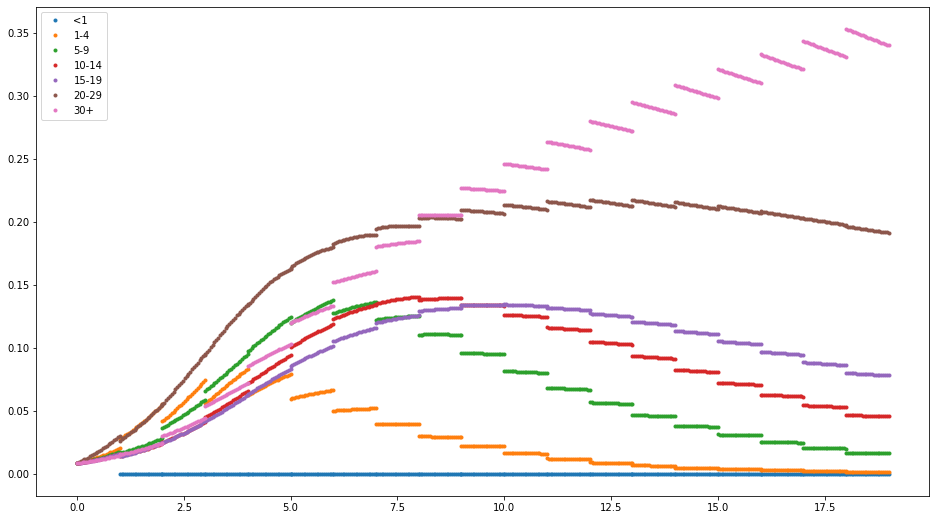

In [89]:
out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t, np.transpose(out[7+ii,:]),".", label = age_class[ii])
plt.legend()

In [63]:
monthly_out = out[7:(7*2),1::2] 

In [64]:
monthly_out.shape

(7, 228)

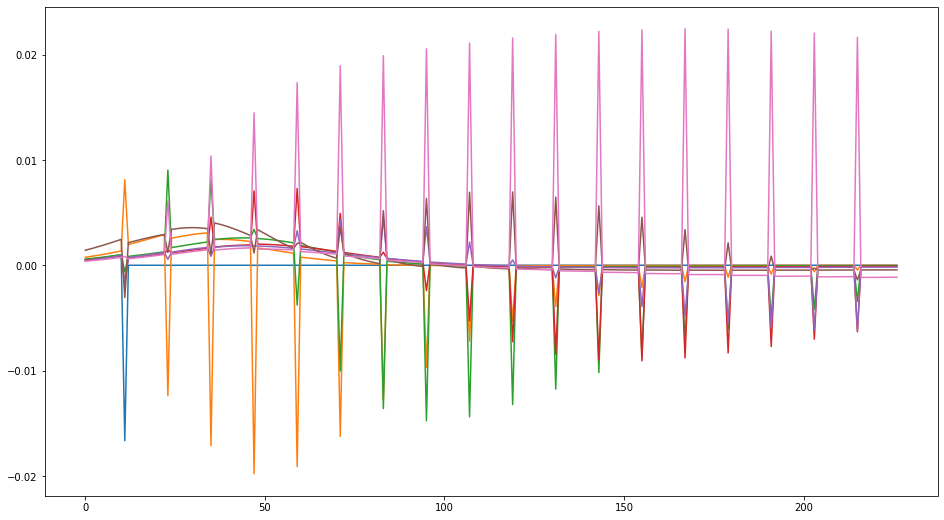

In [65]:
plt.figure(figsize=(16,9))

groups = monthly_out.shape[0]
for ii in range(groups):
    Inf_group = monthly_out[ii,:]
    #monthly data
    monthly_infected_sim = np.diff(Inf_group)
    
    plt.plot(monthly_infected_sim)